# 逻辑回归
>sigomoid function: $\frac{1}{1+e^{-\omega^Tx}}$

用梯度上升算法来求参数,求函数的最大值。

迭代步骤：$$\theta :=\theta+\alpha \cdot \nabla F(\omega) $$

## 训练算法：求参数

>主要步骤如下：
* 将数据转化成矩阵
* 求梯度

In [1]:
from numpy import *
def loadData(filename):
    '''
    读取文件
    '''
    datamat = []; labelmat = []
    with open(filename) as f:
        for line in f.readlines():
            line_arr = line.strip().split()
            #有1.0是因为有一个常数项
            datamat.append([1.0, float(line_arr[0]), float(line_arr[1])])
            labelmat.append(int(line_arr[2]))
    return datamat, labelmat

In [2]:
datamat,labelmat = loadData('testSet.txt')

In [213]:
def sigmoid(inX):
    '''
    sigmoid函数
    -inX:-wT·x
    '''
    return 1.0/(1+exp(-inX))

In [4]:
def gradAscent(dataMatIn,classLabels):
    '''
    梯度上升算法
    dataMatIn:训练样本
    classLabels:标签
    '''
    dataMatrix = mat(dataMatIn)
    labelMat = mat(classLabels).transpose()
    m,n = shape(dataMatrix)
    alpha = 0.001
    maxCycles = 500
    #weights are parameters' vector
    weights = ones((n,1))
    for k in range(maxCycles):
        h = sigmoid(dataMatrix*weights)
        error = (labelMat - h)
        #推导过程如下:
        weights = weights +alpha*dataMatrix.transpose()*error
    return weights

推导：因为代价函数的梯度已知:

\begin{align}
\nabla F(\omega)&=\sum_{n=1}^{N}(y_{n}-sigmoid)x_n\\
&=\sum_{n=1}^{N}(y_n-h) \cdot x_n\\
& = \sum_{n=1}^{N}(error)\cdot x_n\\
\end{align}

In [5]:
weights = gradAscent(datamat,labelmat)

In [6]:
import matplotlib
import matplotlib.pyplot as plt
from numpy import *

def plot_fit(data, labelMat, weights):
    '''
    画图，得到分界线
    data:训练样本
    labelMat:标签矩阵
    '''
    dataArr = array(data)
    n = shape(dataArr)[0]
    
    x_cord1 = []; y_cord1 = []
    x_cord2 = []; y_cord2 = []
    for i in range(n):  
        if int(labelMat[i]) == 1:  
            x_cord1.append(dataArr[i,1]); y_cord1.append(dataArr[i,2])  
        else: x_cord2.append(dataArr[i,1]); y_cord2.append(dataArr[i,2])  
    
    fig = plt.figure()
    ax = fig.add_subplot(111)  
    ax.scatter(x_cord1, y_cord1, s = 30, c = 'red', marker='s')  
    ax.scatter(x_cord2, y_cord2, s = 30, c = 'green')  
    
    x = arange(-3.0, 3.0, 0.1)  
    y = ((-weights[0]- weights[1] * x)/weights[2]).transpose()
    ax.plot(x, y)  
    plt.xlabel('X1');  
    plt.ylabel('X2');  
    plt.show()  

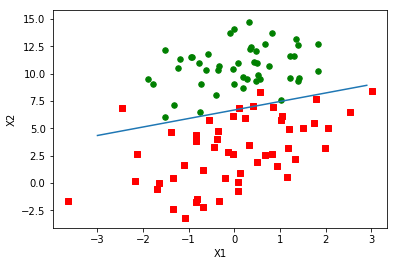

In [7]:
plot_fit(datamat,labelmat,weights)

>梯度下降法分类效果还可以，100个样本分类错误4个，但是计算量太大了，计算了300次乘法，需要进一步改进算法。

## 随机梯度上升
梯度上升每次更新回归系数，都需要遍历整个数据集，一旦特征数量很大，计算复杂度太高了，改进方法叫随机梯度上升算法，每次选择一个样本点来更新回归系数

In [20]:
def stocGradAscent0(dataMatrix,classLabels):
    '''
    随机梯度上升算法
    dataMatrix:训练样本
    calssLabels:标签
    output:参数值
    '''
    m,n = shape(dataMatrix)
    alpha = 0.01
    weights = ones(n)
    for i in range(m):
        h = sigmoid(sum(dataMatrix[i]*weights))
        error = classLabels[i] - h
        weights = weights + alpha*error*array(dataMatrix[i])
    return weights

In [21]:
weight2 = stocGradAscent0(datamat,labelmat)

推导过程：
\begin{align}
\nabla F(\omega)&=N\cdot (y_{i}-sigmoid)x_i\\
& = N\cdot (error)\cdot x_i\\
\end{align}


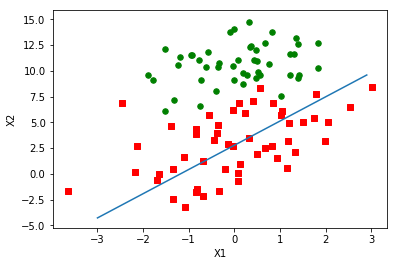

In [22]:
plot_fit(datamat,labelmat,weight2)

>结果显示分类效果比较差，是因为迭代次数不确定导致参数还未达到稳定。可以对上述代码进行进一步修改

In [23]:
def stocGradAscent1(dataMatrix,classLabels,numIter = 150):
    '''
    改进的随机梯度上升算法
    '''
    m,n = shape(dataMatrix)
    weights = ones(n)
    #迭代次数
    for j in range(numIter):
        dataIndex = range(m)
        #样本数量
        for i in range(m):
            #每次调整a，why?
            alpha = 0.01+4/(1.0+j+i)
            #uniform-->生成[x,y)之间的随机实数
            randIndex = int(random.uniform(0,len(dataIndex)))
            h = sigmoid(sum(dataMatrix[randIndex]*weights))
            error = classLabels[randIndex] -h
            weights = weights + alpha*error*array(dataMatrix[randIndex])
    return weights
'''
1.不明白为什么每次需要调整alpha
2.随机选择样本可以减少周期波动
'''

'\n1.不明白为什么每次需要调整alpha\n2.随机选择样本可以减少周期波动\n'

In [24]:
weights3 = stocGradAscent1(datamat,labelmat,10)

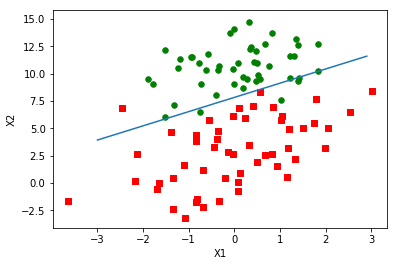

In [25]:
plot_fit(datamat,labelmat,weights3)

## 疝气病预测病马死亡率
用医院检测疝气病的指标，来预测病马的死亡率

> 数据预处理：缺失值处理
* 用特征均值填补
* 用特殊值填补，比如-1
* 忽略这部分样本
* 用类似样本均值填补
* 用机器学习算法来预测

具体做法：
1. 选一个实数值替换，选0
2. 标签缺失，需要丢弃数据

[数据来源](http://archive.ics.uci.edu/ml/datasets/Horse+Colic)

In [185]:
def getDateSet(filepath):
    '''
    获得训练集和测试集
    '''
    import numpy as np
    
    with open(filepath) as f:
        file = f.readlines()
        arr = []
        dataSet = [];Labels=[]#训练集和标签集
        for x in file:
            mid = x.strip().split('\t')
            vector = list(map(lambda x:float(x),mid))
            arr.append(vector)
            #用numpy提取数据集以及标签集,加一个x0项
            mid2 = np.array(arr)
        x0 = array([1]*len(file))
        dataSet = np.column_stack((x0,mid2[:,:-1]))
        Labels =mid2[:,-1] 
    return dataSet,Labels

In [186]:
trainingdataSet,trainingLabels = getDateSet('./horseColicTraining.txt')
testdataSet,testLabels = getDateSet('./horseColicTest.txt')

In [275]:
stocGradAscent1(trainingdataSet,trainingLabels,500)

array([ 2.88523241e+00,  4.60371241e+01, -3.44351209e+00,  1.81776542e+00,
       -1.22312262e+00, -4.51162382e-02, -1.26815180e+01, -5.19715412e+00,
       -1.62249176e+01,  1.69815852e+00, -1.42154178e+01,  2.51022948e+01,
       -1.01675395e+01,  3.62858014e+01, -5.73351142e+00, -7.52889830e+00,
        8.52370700e+00, -9.93327494e+00, -1.10860304e+00,  1.43608141e+00,
       -2.06483905e+00, -5.98332914e+00])

In [276]:
#得到参数
weights = stocGradAscent1(trainingdataSet,trainingLabels,500)
#测试，计算w^tx
result = mat(testdataSet)*mat(weights).T

In [277]:
#sigmoid参数z,是-w^Tx的计算结果，sig
z = result.tolist()
sig = list(map(lambda x:sigmoid(x[0]),result.tolist()))

def classifyVector(x):
    '''
    sigmoid函数计算结果
    '''
    if x >0.5:
        return 1.0
    else:
        return 0.0

In [284]:
#逻辑回归的预测结果
lg_result = [classifyVector(x) for x in sig]
#标签集转列表
testLabels.tolist()
#将预测结果和真实结果zip打包成元组n
zipped = zip(lg_result,testLabels.tolist())
n = list(zipped)
#计算分类错误率
errorRate = len([x for x in n if x[0]-x[1]!=0])/len(n)

>上述代码合并如下：

In [334]:
def errorTest():
    '''
    错误率计算函数
    weights:逻辑回归模型参数
    '''
    #数据集准备
    trainingdataSet,trainingLabels = getDateSet('./horseColicTraining.txt')
    testdataSet,testLabels = getDateSet('./horseColicTest.txt')
    
    #得到参数
    weights = stocGradAscent1(trainingdataSet,trainingLabels,10)
    #测试，计算w^tx
    result = mat(testdataSet)*mat(weights).T
    
    #sigmoid参数z,是-w^Tx的计算结果，sig
    z = result.tolist()
    sig = list(map(lambda x:sigmoid(x[0]),result.tolist()))

    #逻辑回归的预测结果
    lg_result = [classifyVector(x) for x in sig]
    #标签集转列表
    testLabels.tolist()
    #将预测结果和真实结果zip打包成元组n
    zipped = zip(lg_result,testLabels.tolist())
    n = list(zipped)
    #计算分类错误率
    errorRate = len([x for x in n if x[0]-x[1]!=0])/len(n)
    print('错误率:%f'%errorRate)
    return errorRate

In [335]:
errorTest()

错误率:0.283582


0.2835820895522388

In [336]:
def multiTest():
    numTests = 10;errorSum=0.0
    for k in range(numTests):
        errorSum += errorTest()
    print('经过10次迭代后平均错误率:%f'%(float(errorSum/numTests)))

In [337]:
multiTest()

错误率:0.268657
错误率:0.492537
错误率:0.328358
错误率:0.253731
错误率:0.268657
错误率:0.417910
错误率:0.358209
错误率:0.567164
错误率:0.283582
错误率:0.328358
经过10次迭代后平均错误率:0.356716


## 代码整理

In [338]:
def sigmoid(inX):
    '''
    sigmoid函数
    -inX:-wT·x
    '''
    return 1.0/(1+exp(-inX))

def stocGradAscent1(dataMatrix,classLabels,numIter = 150):
    '''
    改进的随机梯度上升算法
    '''
    m,n = shape(dataMatrix)
    weights = ones(n)
    #迭代次数
    for j in range(numIter):
        dataIndex = range(m)
        #样本数量
        for i in range(m):
            #每次调整a，why?
            alpha = 0.01+4/(1.0+j+i)
            #uniform-->生成[x,y)之间的随机实数
            randIndex = int(random.uniform(0,len(dataIndex)))
            h = sigmoid(sum(dataMatrix[randIndex]*weights))
            error = classLabels[randIndex] -h
            weights = weights + alpha*error*array(dataMatrix[randIndex])
    return weights

def getDateSet(filepath):
    '''
    获得训练集和测试集
    '''
    import numpy as np
    
    with open(filepath) as f:
        file = f.readlines()
        arr = []
        dataSet = [];Labels=[]#训练集和标签集
        for x in file:
            mid = x.strip().split('\t')
            vector = list(map(lambda x:float(x),mid))
            arr.append(vector)
            #用numpy提取数据集以及标签集,加一个x0项
            mid2 = np.array(arr)
        x0 = array([1]*len(file))
        dataSet = np.column_stack((x0,mid2[:,:-1]))
        Labels =mid2[:,-1] 
    return dataSet,Labels


def classifyVector(x):
    '''
    sigmoid函数计算结果分类
    '''
    if x >0.5:
        return 1.0
    else:
        return 0.0
    
    
if __name__ =="__main__":
    multiTest()

错误率:0.313433
错误率:0.283582
错误率:0.462687
错误率:0.626866
错误率:0.328358
错误率:0.268657
错误率:0.343284
错误率:0.328358
错误率:0.268657
错误率:0.298507
经过10次迭代后平均错误率:0.352239


## 小结
学习了逻辑回归算法，愈发感受到只看一本书是没有用的，而且《机器学习实战》一书缺陷明显，代码陈旧复杂，推导过程简陋，属于名副其实的入门书籍。有时候照着书上的代码操作结果就是出不来，令人非常恼火。好了，关于这一章的内容，有以下几个注意事项：
>对于逻辑回归模型的本质：__是一个回归模型嵌套在sigmoid函数中，模型借助其阶跃的特点，对样本进行二分类，其问题核心在于求解模型中的参数；从概率的角度来看，由于结果只有0，1，我们认为在拥有数据集的前提下，这些数据往往被取到的概率较大，而概率大小取决于使其取到这些值的参数决定，所以选择某个参数，使得取到数据集的概率最大，这种参数估计方法叫最大似然估计法。关于参数估计，可以使用梯度下降法进行。__

随着学习的深入，更加觉得机器学习并非易事，从数据清洗-特征工程-模型选择-算法优化，这些都包含着高深的学问，此外，还需要有一定的数学基础以及编程能力。不禁感慨一句：
>路漫漫其修远兮，吾将上下而求索。